In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Transformer components

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim: int, n_heads: int):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        assert (
            self.head_dim * n_heads == embed_dim
        ), "embed_dim needs to be divisible by n_heads"

        self.queries = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.keys = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.values = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.fc_out = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(
        self,
        pre_queries: torch.Tensor,
        pre_keys: torch.Tensor,
        pre_values: torch.Tensor,
        mask: torch.Tensor,
    ) -> torch.Tensor:  # shapes of pre_query, pre_key, pre_value are [N, seq_len, embed_dim]. They have the 'pre' prefix because they're the inputs (word vectors) to get the queries, keys, and values
        N = pre_queries.shape[0]  # batch size
        queries_seq_len, keys_seq_len, values_seq_len = pre_queries.shape[1], pre_keys.shape[1], pre_values.shape[1]  # sequence (sentence) lengths which may be different in encoder/decoder

        queries = self.queries(pre_queries)
        keys = self.keys(pre_keys)
        values = self.values(pre_values)

        queries = queries.reshape(N, queries_seq_len, self.n_heads, self.head_dim)
        keys = keys.reshape(N, keys_seq_len, self.n_heads, self.head_dim)
        values = values.reshape(N, values_seq_len, self.n_heads, self.head_dim)

        attention_grid = torch.einsum("nqhd, nkhd -> nhqk", queries, keys)  # shape is [N, self.n_heads, queries_seq_len, keys_seq_len], we sum over self.head_dim

        if mask is not None:
            attention_grid = attention_grid.masked_fill(mask == 0, float("-1e20"))

        attention_weights = torch.softmax(attention_grid / self.head_dim ** (1 / 2), dim=3)  # dim=3 because they need to sum up to one along the key dimension (cuz query asks keys intuitively)

        multi_head = torch.einsum("nhql, nlhd -> nqhd", attention_weights, values)  # this computes all the heads which now need to be concatenated. Shape is [N, query_seq_len, self.n_heads, self.head_dim]
        multi_head_attention = multi_head.reshape(N, queries_seq_len, self.embed_dim)  # concatenation, notice that it's the attention vectors for each corresponding query
        multi_head_attention = self.fc_out(multi_head_attention)  # final weight matrix multiplication

        return multi_head_attention  # shape is [N, queries_seq_len, embed_dim], i.e. the attention vector for each corresponding query vector


class TransformerBlock(nn.Module):
    def __init__(
        self, embed_dim: int, n_heads: int, dropout: float, forward_expansion: int
    ):
        super().__init__()
        self.attention = SelfAttention(embed_dim, n_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.linear_1 = nn.Linear(embed_dim, forward_expansion * embed_dim)
        self.linear_2 = nn.Linear(forward_expansion * embed_dim, embed_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        pre_queries: torch.Tensor,
        pre_keys: torch.Tensor,
        pre_values: torch.Tensor,
        mask: torch.Tensor,
    ) -> torch.Tensor:
        attention = self.attention(pre_queries, pre_keys, pre_values, mask)
        x = self.dropout(self.norm(attention + pre_queries))  # initially, the pre_queries, pre_keys, pre_values are either the same or different if in the decoder, they're just the word vectors
        x_fc = self.linear_2(F.gelu(self.linear_1(x)))
        out = self.dropout(self.norm(x + x_fc))
        return out  # shape is [N, queries_seq_len, embed_dim]


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        embed_dim: int,
        n_layers: int,
        n_heads: int,
        device: torch.device,
        forward_expansion: int,
        dropout: float,
        max_seq_length: int,
    ):
        super().__init__()
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, embed_dim)
        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_dim, n_heads, dropout, forward_expansion)
                for _ in range(n_layers)
            ]
        )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        N, seq_length = x.shape  # seq_length == max_seq_length?
        positions = torch.arange(0, seq_length).expand(N, -1).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))  # these are the word vectors
        for layer in self.layers:
            out = layer(out, out, out, mask)  # calling the forward method of the TransformerBlock
        return out  # shape is [N, x_seq_len, embed_dim]


class DecoderBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        n_heads: int,
        forward_expansion: int,
        dropout: float,
        device: torch.device,
    ):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, n_heads)
        self.transformer_block = TransformerBlock(embed_dim, n_heads, dropout, forward_expansion)
        self.device = device
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        x: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        src_mask: torch.Tensor,
        trg_mask: torch.Tensor,
    ) -> torch.Tensor:  # src_mask is optional, it's so that we don't do computations on padded values. trg_mask is not optional, you MUST have it
        attention = self.attention(x, x, x, trg_mask)
        queries = self.dropout(self.norm(x + attention))  # the queries in the decoder which get passed into the second multiheaded attention
        out = self.transformer_block(queries, keys, values, src_mask)
        return out  # shape is [N, x_seq_len, embed_dim]


class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size: int,
        embed_dim: int,
        n_layers: int,
        n_heads: int,
        device: torch.device,
        forward_expansion: int,
        dropout: float,
        max_seq_length: int,
    ):
        super().__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, embed_dim)
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, n_heads, forward_expansion, dropout, device)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_dim, trg_vocab_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        x: torch.Tensor,
        encoder_out: torch.Tensor,
        src_mask: torch.Tensor,
        trg_mask: torch.Tensor,
    ) -> torch.Tensor:
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, -1).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))
        for layer in self.layers:
            x = layer(x, encoder_out, encoder_out, src_mask, trg_mask)  # encoder output is the attention vector which went through the feedforward nets & normalization + skip connection
        out = self.fc_out(x)  # shape is [N, x_seq_len, trg_vocab_size]
        return out

# Transformer itself (putting it all together)

In [3]:
class Translator(nn.Module):   
    def __init__(
        self, 
        src_vocab_size: int, 
        trg_vocab_size: int, 
        src_pad_idx: int, 
        trg_pad_idx: int, 
        embed_dim: int, 
        n_layers: int, 
        n_heads: int, 
        device: torch.device, 
        forward_expansion: int, 
        dropout: float, 
        max_seq_length: int
    ):
        super().__init__() 
        
        self.encoder = Encoder(
            src_vocab_size, 
            embed_dim, 
            n_layers, 
            n_heads, 
            device, 
            forward_expansion, 
            dropout, 
            max_seq_length
        )
        
        self.decoder = Decoder(
            trg_vocab_size, 
            embed_dim, 
            n_layers, 
            n_heads, 
            device, 
            forward_expansion, 
            dropout, 
            max_seq_length
        )
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device 
        
    def make_src_mask(self, src) -> torch.Tensor:  # src is of shape [N, src sentence length]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)   
        return src_mask.to(self.device)                                 
         
    def make_trg_mask(self, trg) -> torch.Tensor:
        N, trg_length = trg.shape
        trg_mask = torch.tril(torch.ones(trg_length, trg_length)).expand(N, 1, trg_length, trg_length) 
        return trg_mask.to(self.device)
              
    def forward(
        self, 
        src: torch.Tensor,  
        trg: torch.Tensor,
    ) -> torch.Tensor:
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_src_mask(trg)
        encoder_src = self.encoder(src, src_mask)
        out = self.decoder(trg, encoder_src, src_mask, trg_mask)
        return out  

# Data preprocessing and training
I'll be translating from german (src) to english (trg)

In [4]:
import spacy 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from torch.utils.data import DataLoader
from typing import Iterable, List

# !python -m spacy download de
# !python -m spacy download en  # run these if you haven't downloaded these languages from spacy before 

# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

In [5]:
tokenize_ger = get_tokenizer('spacy', language='de_core_news_sm')
tokenize_eng = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data: Iterable, language: str):
    for sample_ger, sample_eng in data: 
        if language == 'de':
            yield tokenize_ger(sample_ger)
        
        elif language == 'en':  
            yield tokenize_eng(sample_eng)
        
train_data, valid_data = Multi30k(split=('train', 'valid'), language_pair=('de', 'en'))

# Define special symbols and indices
unk_idx, pad_idx, sos_idx, eos_idx = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']
vocab_ger = build_vocab_from_iterator(yield_tokens(train_data, 'de'), min_freq=1, specials=special_symbols, special_first=True)
vocab_eng = build_vocab_from_iterator(yield_tokens(train_data, 'en'), min_freq=1, specials=special_symbols, special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
vocab_ger.set_default_index(unk_idx)
vocab_eng.set_default_index(unk_idx)

c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\torch\utils\data\datapipes\iter\combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [6]:
from torch.nn.utils.rnn import pad_sequence

# function to add SOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([sos_idx]), torch.tensor(token_ids), torch.tensor([eos_idx])))

def custom_collate_fn(batch): 
    batch_ger = []  # this is the source  
    batch_eng = []  # this is the target 
    for sample_ger, sample_eng in batch: 
        sample_ger_tokens = tokenize_ger(sample_ger)  # tokenization 
        sample_ger_token_ids = vocab_ger(sample_ger_tokens)  # converting tokens into ids 
        batch_ger.append(tensor_transform(sample_ger_token_ids))
        
        sample_eng_tokens = tokenize_eng(sample_eng)  # tokenization 
        sample_eng_token_ids = vocab_eng(sample_eng_tokens)  # converting tokens into ids 
        batch_eng.append(tensor_transform(sample_eng_token_ids))
    
    batch_ger = pad_sequence(batch_ger, padding_value=pad_idx, batch_first=True)
    batch_eng = pad_sequence(batch_eng, padding_value=pad_idx, batch_first=True)
    return batch_ger, batch_eng

In [7]:
# device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# training hyperparams 
num_epochs = 150
learning_rate = 1e-6
batch_size = 8

# model hyperparams 
src_vocab_size = len(vocab_ger)
trg_vocab_size = len(vocab_eng)
embed_dim = 512 
n_layers = 3
n_heads = 4
forward_expansion = 4
dropout = 0 
max_seq_length = 50

model = Translator(
    src_vocab_size=src_vocab_size,
    trg_vocab_size=trg_vocab_size,
    src_pad_idx=pad_idx,
    trg_pad_idx=pad_idx,  
    embed_dim=embed_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    device=device,
    forward_expansion=forward_expansion,
    dropout=dropout,
    max_seq_length=max_seq_length
).to(device)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
ce_loss = nn.CrossEntropyLoss(ignore_index=pad_idx)

cuda


In [8]:
# useful functions 
def valid_loss_fn(model, valid_dataloader, valid_dataloader_length: int, loss_function, device):
    model.eval()
    loss = 0
    for batch_idx, (batch_ger, batch_eng) in enumerate(valid_dataloader): 
        batch_ger = batch_ger.to(device).to(torch.int64)
        batch_eng = batch_eng.to(device).to(torch.int64)
        
        output = model(batch_ger, batch_eng[:, :-1])
        loss += loss_function(torch.permute(output, (0, 2, 1)), batch_eng[:, 1:])
    model.train()
    return loss/valid_dataloader_length
    
def translate_sentence(model, sentence: str, max_length, device):  # translation is done using greedy decoding. Note that max_length must be less than max_seq_length
    model.eval()
    sentence = tensor_transform(vocab_ger(tokenize_ger(sentence))).unsqueeze(0).to(device)  # i also need to add a singleton batch dimension
    decoder_inputs_list = [sos_idx]
    decoder_inputs = torch.tensor(decoder_inputs_list).unsqueeze(0).to(device)
    for i in range(max_length - 1):
        output = model(sentence, decoder_inputs)  # shape [1, decoder input seq length, vocab size]
        next_word = torch.tensor([torch.argmax(output[0, -1, :])]).unsqueeze(0).to(device)  # select the output from the last element of decoder the sequence to get the next word 
        decoder_inputs = torch.cat((decoder_inputs, next_word), dim=1)
        if next_word == eos_idx:
            break
        
    token_ids = decoder_inputs[0, :].tolist()
    itos = vocab_eng.get_itos()
    tokens = [itos[token] for token in token_ids]
    model.train()
    return tokens  # returns a list of tokens 

In [9]:
# model summary 
from torchinfo import summary 
input_data = list(train_dataloader)[0]
print(input_data[0].shape, input_data[1].shape)
summary(model, input_data=[input_data[0], input_data[1]], device=device, col_names=('input_size', 'output_size', 'num_params'))

torch.Size([8, 18]) torch.Size([8, 17])


c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\Temirkul\anaconda3\envs\temirkul\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
Translator                                    [8, 18]                   [8, 17, 10837]            --
├─Encoder: 1-1                                [8, 18]                   [8, 18, 512]              --
│    └─Embedding: 2-1                         [8, 18]                   [8, 18, 512]              9,837,568
│    └─Embedding: 2-2                         [8, 18]                   [8, 18, 512]              25,600
│    └─Dropout: 2-3                           [8, 18, 512]              [8, 18, 512]              --
│    └─ModuleList: 2-4                        --                        --                        --
│    │    └─TransformerBlock: 3-1             [8, 18, 512]              [8, 18, 512]              3,149,824
│    │    └─TransformerBlock: 3-2             [8, 18, 512]              [8, 18, 512]              3,149,824
│    │    └─TransformerBlock: 3-3             [8, 18, 512]   

In [10]:
for batch_idx, batch in enumerate(train_dataloader):  
    print(batch_idx, len(batch), batch[0].shape, batch[1].shape)
    if batch_idx == 5: 
        break 
train_dataloader_length = len(list(train_dataloader))

for batch_idx, batch in enumerate(valid_dataloader):  
    print(batch_idx, len(batch), batch[0].shape, batch[1].shape)
    if batch_idx == 5: 
        break 
valid_dataloader_length = len(list(valid_dataloader))

print(train_dataloader_length, valid_dataloader_length)

0 2 torch.Size([8, 21]) torch.Size([8, 24])
1 2 torch.Size([8, 19]) torch.Size([8, 18])
2 2 torch.Size([8, 22]) torch.Size([8, 21])
3 2 torch.Size([8, 19]) torch.Size([8, 18])
4 2 torch.Size([8, 21]) torch.Size([8, 20])
5 2 torch.Size([8, 21]) torch.Size([8, 19])
0 2 torch.Size([8, 33]) torch.Size([8, 33])
1 2 torch.Size([8, 18]) torch.Size([8, 21])
2 2 torch.Size([8, 21]) torch.Size([8, 20])
3 2 torch.Size([8, 23]) torch.Size([8, 22])
4 2 torch.Size([8, 24]) torch.Size([8, 25])
5 2 torch.Size([8, 19]) torch.Size([8, 20])
3626 127


In [11]:
# training 
train_loss = np.zeros(num_epochs)
valid_loss = np.zeros(num_epochs)
example_sentence = "Polizist ringt mit einem Mann, der eine Hand in die Luft streckt, während andere Polizisten zusehen."
reference_translation = "Cop wrestle one man with his hand sticking up in the air as other cops watch."

for epoch in range(num_epochs):
    temp_arr = np.zeros(train_dataloader_length)
    for batch_idx, (batch_ger, batch_eng) in enumerate(train_dataloader):
        batch_ger = batch_ger.to(device).to(torch.int64)
        batch_eng = batch_eng.to(device).to(torch.int64)
        
        output = model(batch_ger, batch_eng[:, :-1])  # exclude the <eos> token from the decoder input (because we want to predict it)
        output = output.reshape(-1, output.shape[2])
        loss = ce_loss(output, batch_eng[:, 1:].reshape(-1))  # shift labels by 1 to the right
        temp_arr[batch_idx] = loss 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss[epoch] = np.mean(temp_arr)
    valid_loss[epoch] = valid_loss_fn(model, valid_dataloader, valid_dataloader_length, ce_loss, device)
    
    print(translate_sentence(model, example_sentence, 50, device))
    print(f"Epoch {epoch}")

['<sos>', 'A', 'man', 'in', 'a', 'in', 'a', 'a', 'a', 'a', '.', '<eos>']
Epoch 0
['<sos>', 'Two', 'men', 'in', 'in', 'the', 'in', 'the', 'in', 'in', 'the', 'in', 'the', 'in', 'the', 'in', 'the', 'in', 'the', 'in', 'the', 'in', 'the', 'in', 'the', '<eos>']
Epoch 1
['<sos>', '.', '<eos>']
Epoch 2
['<sos>', '.', '<eos>']
Epoch 3
['<sos>', '.', '<eos>']
Epoch 4
['<sos>', '.', '<eos>']
Epoch 5
['<sos>', '.', '<eos>']
Epoch 6
['<sos>', '.', '<eos>']
Epoch 7
['<sos>', '.', '<eos>']
Epoch 8
['<sos>', '.', '<eos>']
Epoch 9
['<sos>', '.', '<eos>']
Epoch 10
['<sos>', '.', '<eos>']
Epoch 11
['<sos>', '.', '<eos>']
Epoch 12
['<sos>', '.', '<eos>']
Epoch 13
['<sos>', '.', '<eos>']
Epoch 14
['<sos>', '.', '<eos>']
Epoch 15
['<sos>', '.', '<eos>']
Epoch 16
['<sos>', '.', '<eos>']
Epoch 17
['<sos>', '.', '<eos>']
Epoch 18
['<sos>', '.', '<eos>']
Epoch 19
['<sos>', '.', '<eos>']
Epoch 20
['<sos>', '.', '<eos>']
Epoch 21
['<sos>', '.', '<eos>']
Epoch 22
['<sos>', '.', '<eos>']
Epoch 23
['<sos>', '.', '<e

In [12]:
train_example_sentence = "Ein kleiner Junge mit einer blauen Baseballkappe sitzt auf einem Dock und blickt auf das Wasser."  # an example from the training set 
train_reference_translation = "A little boy wearing a blue baseball cap is sitting on a dock overlooking the water."
print(translate_sentence(model, train_example_sentence, 50, device))

['<sos>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '<eos>']


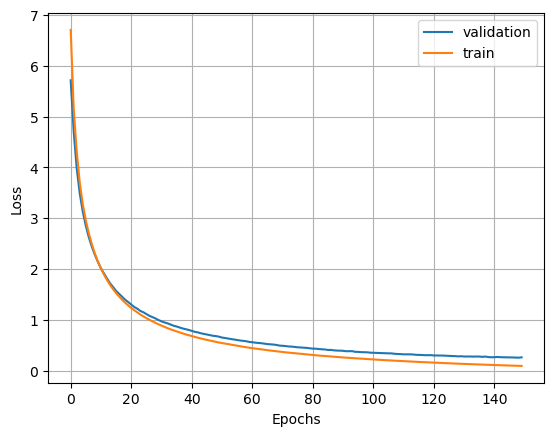

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.arange(num_epochs), valid_loss, label='validation')
plt.plot(np.arange(num_epochs), train_loss, label='train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim(0, 1)
plt.grid()
plt.show()